In [36]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Reading in the csv
wego = pd.read_csv("../data/wego.csv")

In [4]:
# Remove rows where all adjusted counts are 0 - they're mostly NaN values in all columns.
wego = wego.loc[~ ((wego['ADJUSTED_EARLY_COUNT'] == 0) &
             (wego['ADJUSTED_ONTIME_COUNT'] == 0) &
             (wego['ADJUSTED_LATE_COUNT'] == 0)) ]

In [5]:
# Remove rows where the previously scheduled stop was cancelled.
wego = wego[wego['PREV_SCHED_STOP_CANCELLED'] != 1.0]

In [6]:
# Creating percentiles to clean outliers from adherence and headway deviation
# Used quantile instead of percentile, percentile was causing issues due to NaN columns

percentile1adh = wego['ADHERENCE'].quantile(0.001)
print(percentile1adh)

percentile99adh = wego['ADHERENCE'].quantile(0.999)
print(percentile99adh)

percentile1hdwy = wego['HDWY_DEV'].quantile(0.001)
print(percentile1hdwy)

percentile99hdwy = wego['HDWY_DEV'].quantile(0.999)
print(percentile99hdwy)

-57.040499999999994
9.466666
-21.624767162
56.43715000000084


In [7]:
# Removing outliers
wego = wego.drop(wego[wego.ADHERENCE < percentile1adh].index)
wego = wego.drop(wego[wego.ADHERENCE > percentile99adh].index)
wego = wego.drop(wego[wego.HDWY_DEV < percentile1hdwy].index)
wego = wego.drop(wego[wego.HDWY_DEV > percentile99hdwy].index)

In [8]:
wego.shape

(334031, 30)

In [9]:
# Calculating new column, headway deviation percentage

# Dropping the 104 rows where scheduled headway is 0
wego = wego[wego['SCHEDULED_HDWY'] != 0.00]

wego['HDWY_DEV_PERC'] = wego['HDWY_DEV'] / wego['SCHEDULED_HDWY'] * 100

In [10]:
wego[wego['SCHEDULED_HDWY']<1].groupby('TRIP_EDGE')['SCHEDULED_HDWY'].count()

Series([], Name: SCHEDULED_HDWY, dtype: int64)

(array([    0.,     0.,     0.,     0.,     0.,  1135.,  2286.,  2270.,
         2631.,  2965.,  3935.,  4923.,  7223., 10494., 15626., 25105.,
        42495., 47763., 29495., 18364., 11395.,  7955.,  5385.,  3736.,
         3024.,  2243.,  2029.,  1772.,  1739.,  1329.,   911.,   624.,
          492.,   328.,   275.,   210.,   193.,   130.,   114.,   100.]),
 array([-150.  , -141.25, -132.5 , -123.75, -115.  , -106.25,  -97.5 ,
         -88.75,  -80.  ,  -71.25,  -62.5 ,  -53.75,  -45.  ,  -36.25,
         -27.5 ,  -18.75,  -10.  ,   -1.25,    7.5 ,   16.25,   25.  ,
          33.75,   42.5 ,   51.25,   60.  ,   68.75,   77.5 ,   86.25,
          95.  ,  103.75,  112.5 ,  121.25,  130.  ,  138.75,  147.5 ,
         156.25,  165.  ,  173.75,  182.5 ,  191.25,  200.  ]),
 <BarContainer object of 40 artists>)

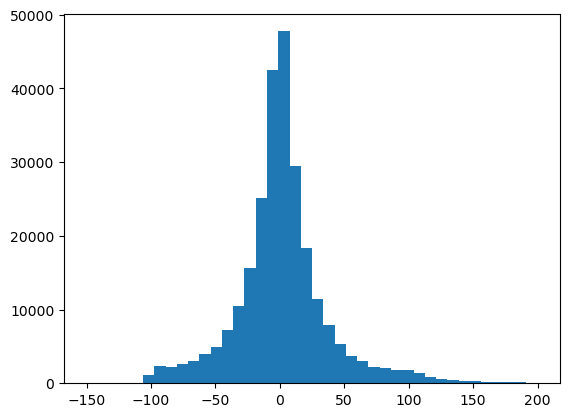

In [11]:
plt.hist(wego.HDWY_DEV_PERC, bins=40, range = (-150, 200))


Bunching occurs when there is shorter headway than scheduled, which would appear as a negative HDWY_DEV value. 
Gapping is when there is more headway than scheduled and appears as a positive value in the HDWY_DEV column. 
Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
The generally accepted range of headway deviation is 50% to 150% of the scheduled headway, 
so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

bunching is <-50

normal is -50 to 50

gapping is >50

In [12]:
# Adding columns to indicate if headway was normal, bunching, or gapping

wego['HDWY_IS_BUNCHING'] = 0
wego['HDWY_IS_NORMAL'] = 0
wego['HDWY_IS_GAPPING'] = 0

def hdwy_cat(row):
    if row['HDWY_DEV_PERC'] < -50:
        row['HDWY_IS_BUNCHING'] = 1
    elif -50 <= row['HDWY_DEV_PERC'] <= 50:
        row['HDWY_IS_NORMAL'] = 1
    elif row['HDWY_DEV_PERC'] > 50:
        row['HDWY_IS_GAPPING'] = 1
    return row

wego = wego.apply(hdwy_cat, axis=1)

In [13]:
wego[['HDWY_IS_BUNCHING', 'HDWY_IS_NORMAL', 'HDWY_IS_GAPPING']].value_counts().sort_values().reset_index()

,HDWY_IS_BUNCHING,HDWY_IS_NORMAL,HDWY_IS_GAPPING,count
0,1,0,0,17243
1,0,0,1,20562
2,0,0,0,72640
3,0,1,0,223482


In [14]:
wego.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,TIME_POINT_ABBR,ROUTE_STOP_SEQUENCE,TRIP_EDGE,LATITUDE,LONGITUDE,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,ACTUAL_DEPARTURE_TIME,ADHERENCE,SCHEDULED_HDWY,ACTUAL_HDWY,HDWY_DEV,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,DWELL_IN_MINS,SCHEDULED_LAYOVER_MINUTES,HDWY_DEV_PERC,HDWY_IS_BUNCHING,HDWY_IS_NORMAL,HDWY_IS_GAPPING
0,120230801,1,99457890,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MHSP,14.0,1,36.181248,-86.847705,2023-08-01 04:42:00,2023-08-01 04:37:38,2023-08-01 04:44:08,-2.133333,NaN,NaN,NaN,0,0,1,0,0.0,0,6.500000,NaN,NaN,0,0,0
1,120230801,1,99457891,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,ELIZ,10.0,0,36.193454,-86.839981,2023-08-01 04:46:00,2023-08-01 04:48:27,2023-08-01 04:48:27,-2.450000,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN,0,0,0
2,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,CV23,5.0,0,36.182177,-86.814445,2023-08-01 04:54:00,2023-08-01 04:54:56,2023-08-01 04:54:56,-0.933333,NaN,NaN,NaN,0,0,1,0,0.0,0,0.000000,NaN,NaN,0,0,0
3,120230801,1,99457893,2023-08-01,22,2200,1040,345104,0,TO DOWNTOWN,MCC5_10,1.0,2,36.167091,-86.781923,2023-08-01 05:10:00,2023-08-01 05:03:43,2023-08-01 05:03:43,6.283333,NaN,NaN,NaN,0,0,1,0,NaN,0,0.000000,NaN,NaN,0,0,0
4,120230801,1,99457894,2023-08-01,22,2200,1040,345105,0,FROM DOWNTOWN,MCC5_10,1.0,1,36.167091,-86.781923,2023-08-01 05:15:00,2023-08-01 05:03:43,2023-08-01 05:16:35,-1.583333,NaN,NaN,NaN,0,0,1,0,0.0,0,12.866666,5.0,NaN,0,0,0


# Q1
### What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like?

In [127]:
# Percent of on-time stops
round(wego['ADJUSTED_ONTIME_COUNT'].mean()*100, 2)

79.9

In [128]:
# Percent of early stops
round(wego['ADJUSTED_EARLY_COUNT'].mean()*100, 2)

2.83

In [129]:
# Percent of late stops
round(wego['ADJUSTED_LATE_COUNT'].mean()*100, 2)

17.27

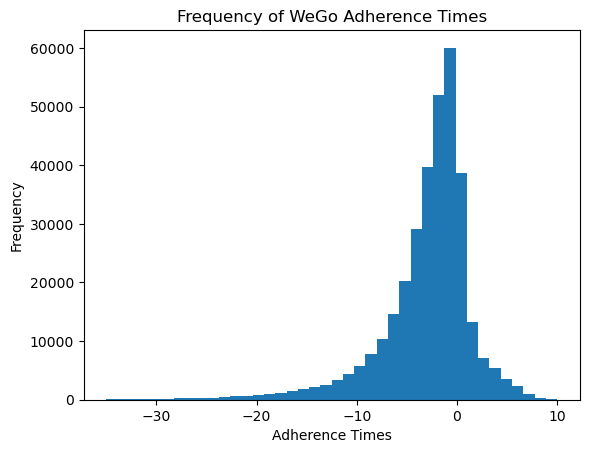

In [18]:
# Adherence distribution - removing non-visible outliers
plt.hist(wego.ADHERENCE, bins=40, range=(-35, 10))
plt.title('Frequency of WeGo Adherence Times')
plt.xlabel('Adherence Times')
plt.ylabel('Frequency')
plt.show() 

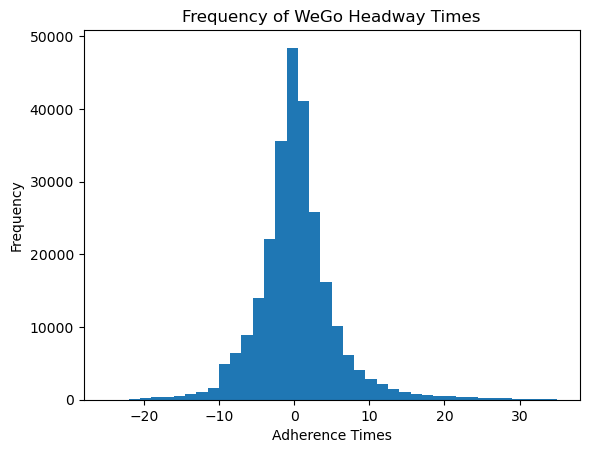

In [19]:
# Headway distribution - removing non-visible outliers
plt.hist(wego.HDWY_DEV, bins=40, range=(-25, 35))
plt.title('Frequency of WeGo Headway Times')
plt.xlabel('Adherence Times')
plt.ylabel('Frequency')
plt.show() 

# Q2
### How does direction of travel, route, or location affect the headway and on-time performance?

In [20]:
# Adjusted late perc will be very diff  
# on time perc: round((wego['ADJUSTED_ONTIME_COUNT'].sum()) / (wego.shape[0]) * 100, 2)
# Route is route_abbr (8 diff)
# Location is lat and long??? - Time point abbr is also location. maybe do groupby

### Direction of Travel

In [21]:
# Headway

pd.options.display.float_format = '{:.2f}'.format

wego.groupby('ROUTE_DIRECTION_NAME')['HDWY_DEV_PERC'].agg(['min', 'mean', 'median', 'max']).reset_index()

,ROUTE_DIRECTION_NAME,min,mean,median,max
0,FROM DOWNTOWN,-100.00,3.04,0.17,2417.50
1,TO DOWNTOWN,-100.00,2.03,0.17,551.39


In [117]:
# On time performance
direction_otp = wego.groupby('ROUTE_DIRECTION_NAME')['ADJUSTED_ONTIME_COUNT'].mean()\
    .to_frame().reset_index().rename(columns={0: 'ON_TIME_PERFORMANCE'})

########## I don't have this part working yet, also want to add early_perf
#direction_otp['LATE_PERFORMANCE'] = (wego.groupby('ROUTE_DIRECTION_NAME')['ADJUSTED_LATE_COUNT'].sum()) / (wego.groupby('ROUTE_DIRECTION_NAME').size()) * 100

In [23]:
direction_otp

,ROUTE_DIRECTION_NAME,ON_TIME_PERFORMANCE,LATE_PERFORMANCE
0,FROM DOWNTOWN,75.22,NaN
1,TO DOWNTOWN,85.17,NaN


### Route

In [24]:
route_names = {
    3: 'West End',
    7: 'Hillsboro',
    22: 'Bordeaux',
    23: 'Dickerson Pike',
    50: 'Charlotte Pike',
    52: 'Nolensville Pike',
    55: 'Murfreesboro Pike',
    56: 'Gallatin Pike'
}

In [25]:
# Headway
wego.groupby('ROUTE_ABBR')['HDWY_DEV_PERC'].agg(['min', 'mean', 'median', 'max']).reset_index() \
    .assign(ROUTE_ABBR=lambda x: x['ROUTE_ABBR'].map(route_names))\
    .rename(columns={'ROUTE_ABBR': 'ROUTE'})

,ROUTE,min,mean,median,max
0,West End,-100.00,5.00,0.54,2417.50
1,Hillsboro,-99.67,2.01,0.11,551.39
2,Bordeaux,-99.44,2.56,0.19,322.64
3,Dickerson Pike,-99.86,4.36,0.33,285.56
4,Charlotte Pike,-99.89,0.89,0.11,282.33
5,Nolensville Pike,-100.00,3.18,0.36,449.05
6,Murfreesboro Pike,-100.00,1.99,-0.33,616.67
7,Gallatin Pike,-100.00,1.09,0.00,286.17


In [114]:
# On time performance

wego.groupby('ROUTE_ABBR')['ADJUSTED_ONTIME_COUNT'].mean()\
    .to_frame().reset_index().rename(columns={'ROUTE_ABBR': 'ROUTE', 'ADJUSTED_ONTIME_COUNT': 'ON_TIME_PERFORMANCE'}) \
    .assign(ROUTE=lambda x: x['ROUTE'].map(route_names))

,ROUTE,ON_TIME_PERFORMANCE
0,West End,0.76
1,Hillsboro,0.78
2,Bordeaux,0.89
3,Dickerson Pike,0.89
4,Charlotte Pike,0.85
5,Nolensville Pike,0.77
6,Murfreesboro Pike,0.70
7,Gallatin Pike,0.82


### Location

In [27]:
# Headway
wego.groupby('TIME_POINT_ABBR')['HDWY_DEV_PERC'].agg(['min', 'mean', 'median', 'max']).reset_index()

,TIME_POINT_ABBR,min,mean,median,max
0,21BK,-99.67,2.40,0.11,551.39
1,25ACLARK,-55.13,1.80,-0.27,125.23
2,28&CHARL,-99.89,0.82,0.33,244.00
3,ARTS,NaN,NaN,NaN,NaN
4,BRCJ,-99.17,9.83,0.33,2417.50
...,...,...,...,...,...
56,WE23,-99.83,4.57,0.83,1467.50
57,WE31,-100.00,4.68,0.42,1541.67
58,WHBG,-99.78,1.24,0.17,278.22
59,WMRT,-99.90,2.10,0.00,449.05


In [110]:
# On time performance
wego.groupby('TIME_POINT_ABBR')['ADJUSTED_ONTIME_COUNT'].mean()\
    .to_frame().reset_index().rename(columns={'ADJUSTED_ONTIME_COUNT': 'ON_TIME_PERFORMANCE'})

,TIME_POINT_ABBR,ON_TIME_PERFORMANCE
0,21BK,0.73
1,25ACLARK,0.98
2,28&CHARL,0.85
3,ARTS,0.59
4,BRCJ,0.77
...,...,...
56,WE23,0.73
57,WE31,0.74
58,WHBG,0.78
59,WMRT,0.79


# Q3
### How does time of day or day of week affect headway and on-time performance?

In [148]:
# Pulling hour and day out of scheduled arrival time
wego['hour'] = pd.to_datetime(wego['SCHEDULED_TIME'], format='mixed').dt.hour
wego['day'] = pd.to_datetime(wego['SCHEDULED_TIME'], format='mixed').dt.day_name()

# Removing rows with no headway data for clean calculations
wego_hdwy = wego[((wego['HDWY_IS_NORMAL'] != 0) | 
                  (wego['HDWY_IS_BUNCHING'] != 0) | 
                  (wego['HDWY_IS_GAPPING'] != 0))]

### Headway

In [152]:
# # Creating dataframe to look at headway deviation perc by day and hour
# dh = wego_hdwy.groupby(['day','hour'])['HDWY_DEV_PERC'].mean().reset_index()

# # Graphing this data with Seaborn

# # Defining the order of days of the week
# days_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# # Creating the FacetGrid
# g = sns.FacetGrid(dh, 
#                   col="day", 
#                   col_order=days_of_week_order, 
#                   col_wrap=4)
# g.map_dataframe(sns.barplot, 
#                 x="hour", 
#                 y="HDWY_DEV_PERC", 
#                 palette='husl')

# # Fine Tuning
# g.fig.suptitle("Headway Deviation Percentage by Hour and Day", fontsize=16, y=1.05)
# g.set_axis_labels("Hour of Day", "Headway Deviation Percentage")
# g.set_titles("{col_name}")
# g.set_xticklabels(rotation=45)

# # Show the plot
# plt.show()

In [153]:
# # Creating dataframe to look at headway deviation perc by hour
# h = wego_hdwy.groupby('hour')['HDWY_DEV_PERC'].mean().reset_index()

# # Plotting
# sns.barplot(
#     x="hour", 
#     y="HDWY_DEV_PERC",
#     data=h, 
#     errorbar=None)

# # Fine tuning
# plt.xlabel("Hour of Day", fontsize=12)
# plt.ylabel("Headway Deviation Percentage", fontsize=12)
# plt.title("Headway Deviation Percentage by Hour of Day", fontsize=14)

# plt.show()

In [178]:
# # Grouped bar chart version for hour

# h = wego_hdwy.groupby('hour')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index()

# # Multiply the means by 100 to convert them to percentages
# h[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] = h[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] * 100

# # Melt the DataFrame to get it in a long format
# hmelt = h.melt(id_vars='hour', value_vars=['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING'], 
#                   var_name='Headway Category', value_name='Headway Perc')

# # Plotting
# sns.barplot(x='hour', 
#             y='Headway Perc', 
#             hue='Headway Category', 
#             data=hmelt)

# # Fine tuning
# plt.xlabel("Hour of Day", fontsize=12)
# plt.ylabel("Percentage", fontsize=12)
# plt.title("Headway Categories by Hour of Day", fontsize=14)
# plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
# plt.show()

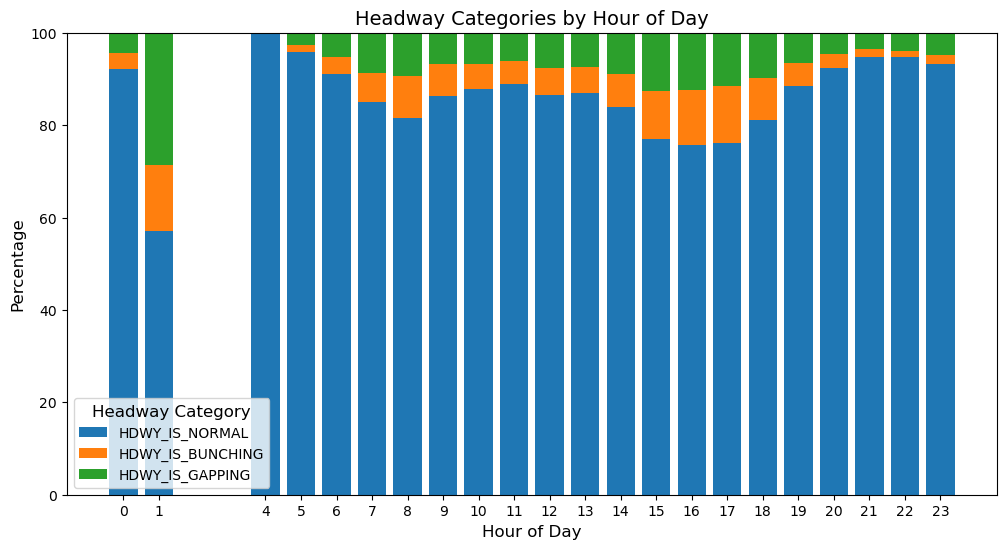

In [170]:
# Stacked bar chart version for hour

hours = h['hour']
normal = h['HDWY_IS_NORMAL']
bunching = h['HDWY_IS_BUNCHING']
gapping = h['HDWY_IS_GAPPING']

plt.figure(figsize=(12, 6))
plt.bar(hours, normal, label='HDWY_IS_NORMAL')
plt.bar(hours, bunching, bottom=normal, label='HDWY_IS_BUNCHING')
plt.bar(hours, gapping, bottom=normal+bunching, label='HDWY_IS_GAPPING')

# Fine tuning
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Headway Categories by Hour of Day', fontsize=14)
plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.xticks(hours)  # Shows all the hour labels - might remove this
plt.show()

In [179]:
# # Grouped bar chart version for day

# # Creating dataframe to look at headway deviation perc by day
# d = wego_hdwy.groupby('day')[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']].mean().reset_index()

# # Multiply the means by 100 to convert them to percentages
# d[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] = d[['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING']] * 100

# # Melt the DataFrame to get it in a long format
# dmelt = d.melt(id_vars='day', value_vars=['HDWY_IS_NORMAL', 'HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING'], 
#                   var_name='Headway Category', value_name='Headway Perc')

# # Plotting
# sns.barplot(x='day', 
#             y='Headway Perc', 
#             hue='Headway Category', 
#             data=dmelt)

# # Fine tuning
# plt.xlabel('Day of Week', fontsize=12)
# plt.ylabel('Percentage', fontsize=12)
# plt.title("Headway Categories by Day of Week", fontsize=14)
# plt.legend(title='Headway Category', fontsize=10, title_fontsize=12)
# plt.show()

# plt.show()

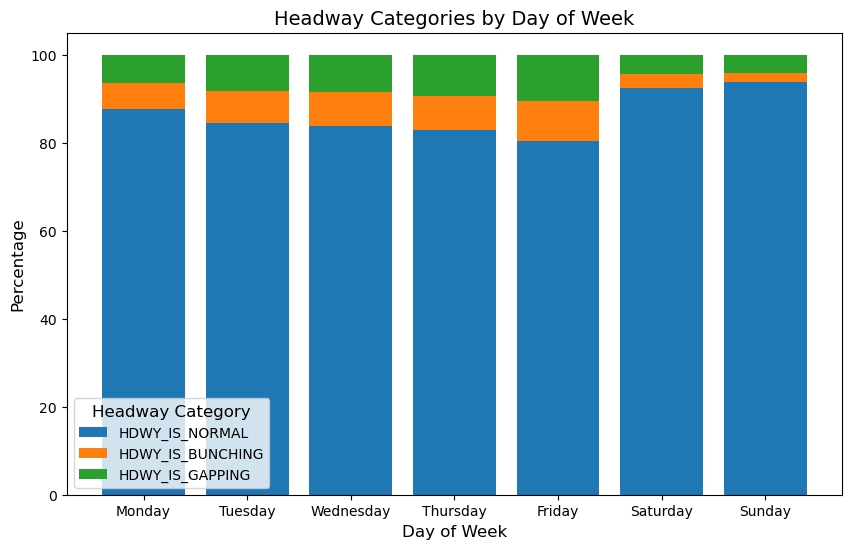

In [175]:
# Stacked bar chart version for day of week

d = d.set_index('day').loc[days_of_week_order].reset_index()

hours = d['day']
normal = d['HDWY_IS_NORMAL']
bunching = d['HDWY_IS_BUNCHING']
gapping = d['HDWY_IS_GAPPING']

fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(hours, normal, label='HDWY_IS_NORMAL')
plt.bar(hours, bunching, bottom=normal, label='HDWY_IS_BUNCHING')
plt.bar(hours, gapping, bottom=normal+bunching, label='HDWY_IS_GAPPING')

# Fine tuning
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Headway Categories by Day of Week', fontsize=14)
ax.legend(title='Headway Category', fontsize=10, title_fontsize=12)
plt.show()

In [154]:
# # Creating dataframe to look at headway deviation perc by day
# d = wego_hdwy.groupby('day')['HDWY_DEV_PERC'].mean().reset_index()

# # Plotting
# sns.barplot(
#     x="day", 
#     y="HDWY_DEV_PERC",
#     data=d,
#     order=days_of_week_order,
#     palette='husl',
#     errorbar=None)

# # Fine tuning
# plt.xlabel("Day of Week", fontsize=12)
# plt.ylabel("Headway Deviation Percentage", fontsize=12)
# plt.title("Headway Deviation Percentage by Day of Week", fontsize=14)

# plt.show()

### On-Time Performance

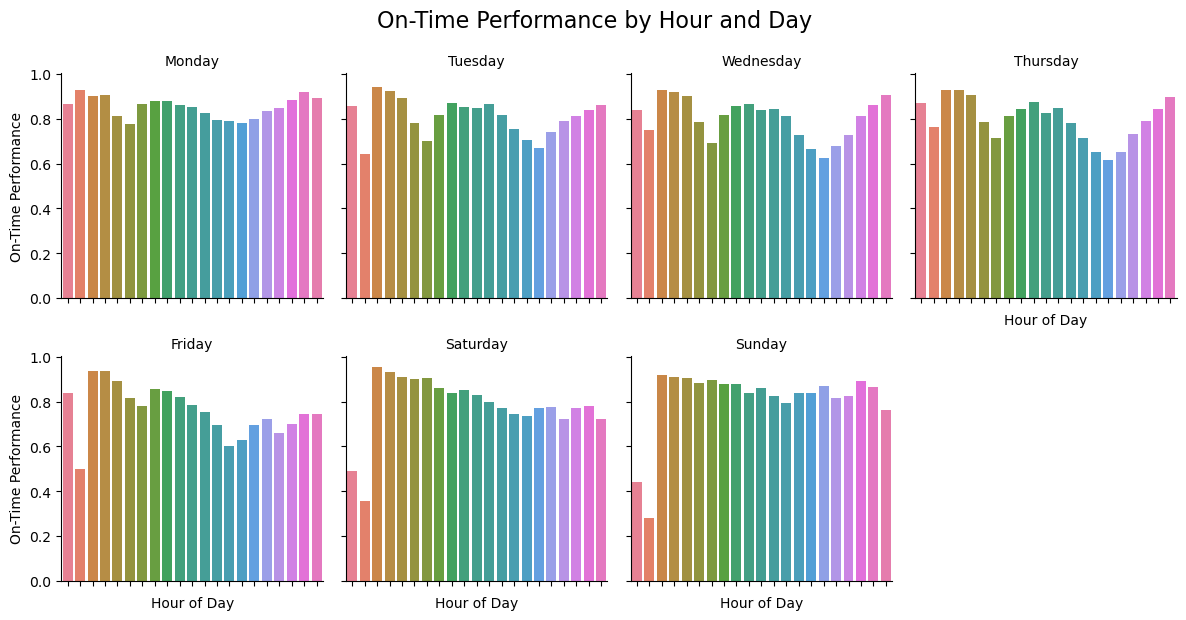

In [89]:
# Creating dataframe to look at OTP by day and hour
dh2 = ((wego.groupby(['day','hour'])['ADJUSTED_ONTIME_COUNT']
        .mean().to_frame().reset_index().rename(columns={'ADJUSTED_ONTIME_COUNT': 'ON_TIME_PERFORMANCE'})))

# Graphing this data with Seaborn

# Defining the order of days of the week
days_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Creating the FacetGrid
g = sns.FacetGrid(dh2, 
                  col="day",
                  col_order=days_of_week_order,
                  col_wrap=4)
g.map_dataframe(sns.barplot, 
                x="hour", 
                y="ON_TIME_PERFORMANCE", 
                palette='husl')

# Fine Tuning
g.fig.suptitle("On-Time Performance by Hour and Day", fontsize=16, y=1.05)
g.set_axis_labels("Hour of Day", "On-Time Performance")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45)

# Show the plot
plt.show()

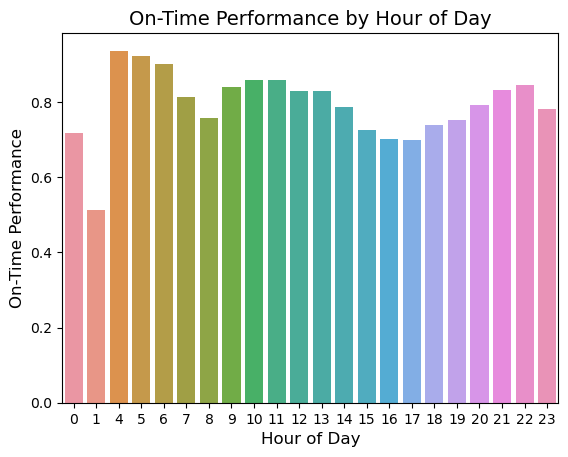

In [87]:
# Creating dataframe to look at OTP by hour
h2 = ((wego.groupby('hour')['ADJUSTED_ONTIME_COUNT']
       .mean().to_frame().reset_index().rename(columns={'ADJUSTED_ONTIME_COUNT': 'ON_TIME_PERFORMANCE'})))

# Plotting
sns.barplot(
    x="hour", 
    y="ON_TIME_PERFORMANCE",
    data=h2, 
    errorbar=None)

# Fine tuning
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("On-Time Performance", fontsize=12)
plt.title("On-Time Performance by Hour of Day", fontsize=14)

plt.show()

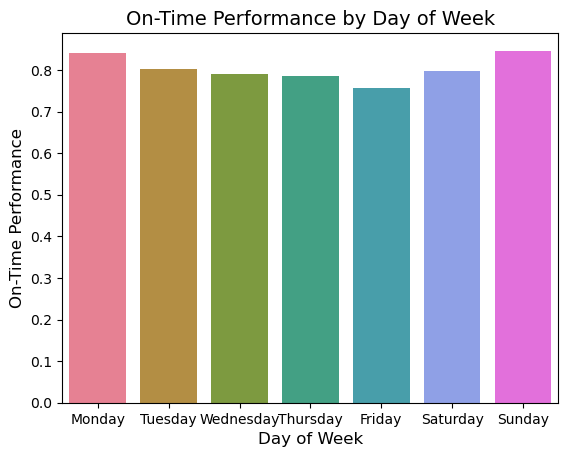

In [98]:
# Creating dataframe to look at OTP by day
d2 = ((wego.groupby('day')['ADJUSTED_ONTIME_COUNT']
       .mean().to_frame().reset_index().rename(columns={'ADJUSTED_ONTIME_COUNT': 'ON_TIME_PERFORMANCE'})))

# Plotting
sns.barplot(
    x="day", 
    y="ON_TIME_PERFORMANCE",
    data=d2,
    order=days_of_week_order,
    palette='husl',
    errorbar=None)

# Fine tuning
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("On-Time Performance", fontsize=12)
plt.title("On-Time Performance by Day of Week", fontsize=14)

plt.show()

In [108]:
# Headway - corrected on #3, fix #2 also
# boxplot for days of week???
# Redo all OTP... need to be OT, E, and L

In [109]:
wego.groupby('day')[['HDWY_IS_BUNCHING', 'HDWY_IS_GAPPING', 'HDWY_IS_NORMAL']].mean().reset_index()

,day,HDWY_IS_BUNCHING,HDWY_IS_GAPPING,HDWY_IS_NORMAL
0,Friday,0.07,0.08,0.63
1,Monday,0.05,0.05,0.69
2,Saturday,0.02,0.03,0.72
3,Sunday,0.02,0.03,0.73
4,Thursday,0.06,0.07,0.65
5,Tuesday,0.06,0.07,0.66
6,Wednesday,0.06,0.07,0.66


In [130]:
wego.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333927 entries, 0 to 350328
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                333927 non-null  int64  
 1   SERVICE_ABBR               333927 non-null  int64  
 2   ADHERENCE_ID               333927 non-null  int64  
 3   DATE                       333927 non-null  object 
 4   ROUTE_ABBR                 333927 non-null  int64  
 5   BLOCK_ABBR                 333927 non-null  int64  
 6   OPERATOR                   333927 non-null  int64  
 7   TRIP_ID                    333927 non-null  int64  
 8   OVERLOAD_ID                333927 non-null  int64  
 9   ROUTE_DIRECTION_NAME       333927 non-null  object 
 10  TIME_POINT_ABBR            333927 non-null  object 
 11  ROUTE_STOP_SEQUENCE        333922 non-null  float64
 12  TRIP_EDGE                  333927 non-null  int64  
 13  LATITUDE                   333927 

In [ ]:
# 4: how many operators are there, and how many routes did they each drive? 
# Come up with cutoff (ex 500 trips or less, drop them; 